In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the GPU device
    device = torch.device("cuda")

    # Get the GPU name
    gpu_name = torch.cuda.get_device_name(0)

    # Get the GPU memory in bytes
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory

    # Convert bytes to gigabytes
    gpu_memory_gb = gpu_memory_bytes / (1024 ** 3)

    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory_gb:.2f} GB")
else:
    print("No GPU available. Switch to a GPU runtime in Colab.")


GPU: Tesla T4
GPU Memory: 14.75 GB


#VGG19

In [ ]:
import tensorflow as tf

#Loading data

In [1]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Specify the path to the 'image_data' folder in your Google Drive
data_path = '/content/gdrive/My Drive/data'

# Load the entire dataset without mini-batches
datauc = tf.keras.utils.image_dataset_from_directory(data_path,
                                                     batch_size= 32,  # Set batch_size to None
                                                     image_size=(224, 224), seed = 42)

# Check the length of the entire dataset
num_samples_in_dataset = len(datauc)
print(f"Number of samples in the dataset: {num_samples_in_dataset}")


Mounted at /content/gdrive
Found 16087 files belonging to 3 classes.
Number of samples in the dataset: 503


In [ ]:
tf.keras.utils.image_dataset_from_directory??

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

#Converting into Numpy Iterator

In [ ]:
data_iterator = datauc.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].min()

-2.079373

#Scaling

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to normalize the images
def normalize_images(image, label):
    # Convert pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Normalize using VGG19 mean and standard deviation
    image = (image - mean) / std

    return image, label

# Apply normalization to the 'datas' dataset
datauc = datauc.map(normalize_images)

#Train Test Split

In [6]:
train_size = int(len(datauc) * 0.7)

val_size = int(len(datauc) * 0.2)

test_size = int(len(datauc) * 0.1)



In [7]:
train = datauc.take(train_size)
val = datauc.skip(train_size).take(val_size)
test = datauc.skip(train_size + val_size).take(test_size)

In [ ]:
len(train)

352

#Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
model = Sequential()


In [ ]:
from keras.regularizers import l2

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#Model Customization

In [ ]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0000018)))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0018)))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0018)))
model.add(Dense(3, activation='softmax'))
# Freeze the layers of the VGG19 base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#Training

In [ ]:
history = History()
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[history])

Epoch 1/50
352/352 [==============================] - 840s 2s/step - loss: 0.5588 - accuracy: 0.8920 - val_loss: 0.3226 - val_accuracy: 0.9516
Epoch 2/50
352/352 [==============================] - 94s 265ms/step - loss: 0.2774 - accuracy: 0.9620 - val_loss: 0.2765 - val_accuracy: 0.9563
Epoch 3/50
352/352 [==============================] - 95s 269ms/step - loss: 0.1920 - accuracy: 0.9767 - val_loss: 0.2243 - val_accuracy: 0.9616
Epoch 4/50
352/352 [==============================] - 98s 277ms/step - loss: 0.1405 - accuracy: 0.9834 - val_loss: 0.1900 - val_accuracy: 0.9709
Epoch 5/50
352/352 [==============================] - 101s 285ms/step - loss: 0.1169 - accuracy: 0.9841 - val_loss: 0.1846 - val_accuracy: 0.9625
Epoch 6/50
352/352 [==============================] - 101s 286ms/step - loss: 0.0974 - accuracy: 0.9835 - val_loss: 0.1598 - val_accuracy: 0.9688
Epoch 7/50
352/352 [==============================] - 101s 285ms/step - loss: 0.0778 - accuracy: 0.9873 - val_loss: 0.2313 - val_a

#(Train loss, Val loss) VS epoch

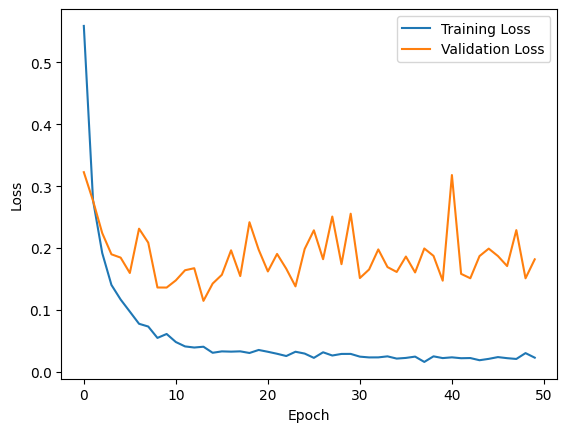

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model, save_model
save_model(model, '/content/drive/MyDrive/your_model.h5')

<ipython-input-26-ee146208f587>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, '/content/drive/MyDrive/your_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/your_model.h5')

#Testing with test data

In [ ]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
sparse_accuracy = SparseCategoricalAccuracy()
for bat in test.as_numpy_iterator():
    X, y = bat
    yhat = model.predict(X)
    sparse_accuracy.update_state(y, yhat)
print("Test Accuracy: ", sparse_accuracy.result())

1/1 [==============================] - 0s 26ms/step
Test Accuracy:  tf.Tensor(0.973125, shape=(), dtype=float32)


#Saving the trained model

In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model, save_model

# Your code goes here

# Save the model to a file
save_model(model, 'your_model.h5')

# Download the file to your local computer
files.download('your_model.h5')

<ipython-input-30-d65265369499>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'your_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#evaluation

In [2]:
import shutil

# Replace 'path/to/your/model' with the actual path of your model in Google Drive
drive_model_path = '/content/gdrive/MyDrive/vgg19banana.h5'
colab_model_path = '/content/model'

shutil.copyfile(drive_model_path, colab_model_path)


'/content/model'

In [4]:
model_path = '/content/model'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)

# Example: Print model summary
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [8]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'test' is a TensorFlow dataset
# Replace 'your_model' with your actual trained model
model = loaded_model

# Initialize empty arrays to store predictions and true labels
all_y_pred = np.array([], dtype=int)
all_true_labels = np.array([], dtype=int)

# Iterate through test batches
for batch in test.as_numpy_iterator():
    # Assuming 'model' is your trained model
    Y_pred_batch = model.predict(batch[0])  # assuming batch[0] contains input data
    y_pred_batch = np.argmax(Y_pred_batch, axis=1)

    # Concatenate batch predictions and true labels to the overall arrays
    all_y_pred = np.concatenate([all_y_pred, y_pred_batch])
    all_true_labels = np.concatenate([all_true_labels, batch[1]])  # assuming batch[1] contains true labels

# After processing all test batches, print the classification report
print(classification_report(all_true_labels, all_y_pred))


1/1 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       583
           1       0.98      0.94      0.96       469
           2       0.98      0.99      0.99       548

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



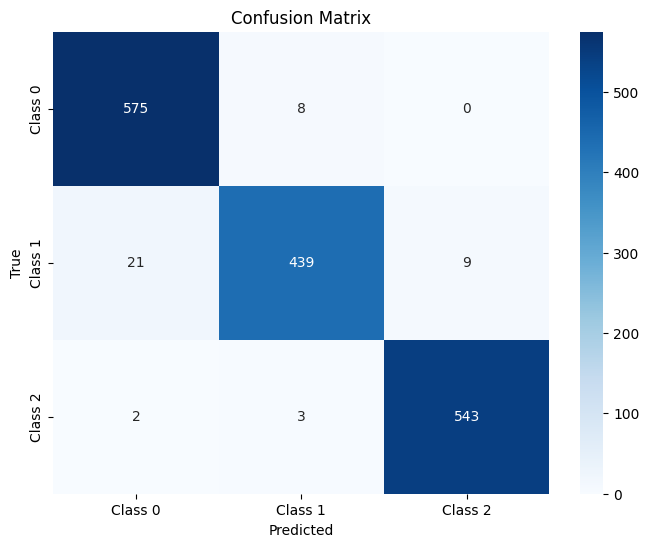

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'all_true_labels' and 'all_y_pred' are already defined

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#NasNetLarge

In [ ]:
import tensorflow as tf

#data loading

In [1]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Specify the path to the 'image_data' folder in your Google Drive
data_path = '/content/gdrive/My Drive/data'

# Load the entire dataset without mini-batches
dataNasu = tf.keras.utils.image_dataset_from_directory(data_path,
                                                     batch_size= 32,  # Set batch_size to None
                                                     image_size=(224, 224), seed = 42)

# Check the length of the entire dataset
num_samples_in_dataset = len(dataNasu)
print(f"Number of samples in the dataset: {num_samples_in_dataset}")

Mounted at /content/gdrive
Found 16087 files belonging to 3 classes.
Number of samples in the dataset: 503


#Normalization

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to normalize the images
def normalize_images(image, label):
    # Convert pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Normalize using VGG19 mean and standard deviation
    image = (image - mean) / std

    return image, label

# Apply normalization to the 'datas' dataset
dataNasu = dataNasu.map(normalize_images)

#Converting to iterator

In [ ]:
data_iterator = dataNasu.as_numpy_iterator()

In [ ]:
batchs = data_iterator.next()

In [ ]:
batchs[0].max()

2.64

#splitting

In [3]:
train_size = int(len(dataNasu) * 0.7)

val_size = int(len(dataNasu) * 0.2)

test_size = int(len(dataNasu) * 0.1)

In [4]:
trainNas = dataNasu.take(train_size)
valNas = dataNasu.skip(train_size).take(val_size)
testNas = dataNasu.skip(train_size + val_size).take(test_size)

#depedencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping

#model customizatin

In [ ]:
base_Nas = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
modelNas = Sequential()

In [ ]:
from keras.regularizers import l2

In [ ]:
modelNas.add(base_Nas)
modelNas.add(Flatten())
modelNas.add(Dense(256, activation='relu', kernel_regularizer=l2(0.00000018)))
modelNas.add(Dropout(0.22))
modelNas.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00018)))
modelNas.add(Dropout(0.21))
modelNas.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00018)))
modelNas.add(Dense(3, activation='softmax'))
# Freeze the layers of the VGG19 base
for layer in base_Nas.layers:
    layer.trainable = False

In [ ]:
modelNas.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#training

In [ ]:
# @title
historyNas = History()
hist = modelNas.fit(trainNas, epochs = 50, validation_data = valNas, callbacks=[historyNas])

Epoch 1/50
352/352 [==============================] - 1542s 4s/step - loss: 0.8067 - accuracy: 0.8591 - val_loss: 0.3172 - val_accuracy: 0.9303
Epoch 2/50
352/352 [==============================] - 206s 583ms/step - loss: 0.3332 - accuracy: 0.9238 - val_loss: 0.2449 - val_accuracy: 0.9466
Epoch 3/50
352/352 [==============================] - 206s 584ms/step - loss: 0.2324 - accuracy: 0.9506 - val_loss: 0.2740 - val_accuracy: 0.9475
Epoch 4/50
352/352 [==============================] - 205s 580ms/step - loss: 0.1404 - accuracy: 0.9698 - val_loss: 0.2184 - val_accuracy: 0.9553
Epoch 5/50
352/352 [==============================] - 205s 581ms/step - loss: 0.1408 - accuracy: 0.9753 - val_loss: 0.3017 - val_accuracy: 0.9522
Epoch 6/50
352/352 [==============================] - 205s 583ms/step - loss: 0.1172 - accuracy: 0.9786 - val_loss: 0.2480 - val_accuracy: 0.9591
Epoch 7/50
352/352 [==============================] - 207s 585ms/step - loss: 0.0889 - accuracy: 0.9854 - val_loss: 0.2510 - v

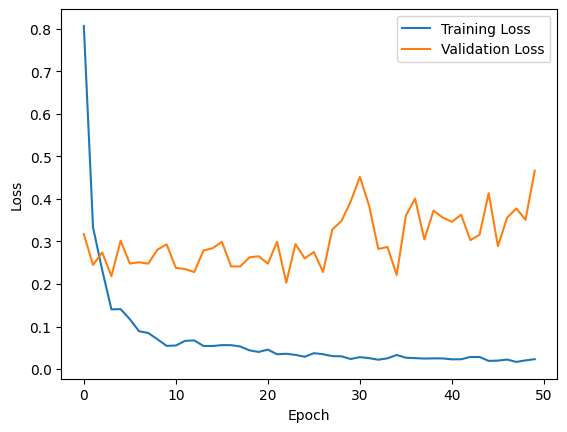

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Test Accuracy

In [ ]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
sparse_accuracy = SparseCategoricalAccuracy()
for batu in testNas.as_numpy_iterator():
    X, y = batu
    yhat = modelNas.predict(X)
    sparse_accuracy.update_state(y, yhat)
print("Test Accuracy: ", sparse_accuracy.result())

1/1 [==============================] - 0s 207ms/step
Test Accuracy:  tf.Tensor(0.95625, shape=(), dtype=float32)


#saving model

In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model, save_model

# Your code goes here

# Save the model to a file
save_model(modelNas, 'NasNetbananas.h5')

# Download the file to your local computer
files.download('NasNetbananas.h5')

<ipython-input-28-5de8e572dd2e>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(modelNas, 'NasNetbananas.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#evaluation

In [5]:
import shutil

# Replace 'path/to/your/model' with the actual path of your model in Google Drive
drive_model_path = '/content/gdrive/MyDrive/NasNetbananas.h5'
colab_model_path = '/content/model'

shutil.copyfile(drive_model_path, colab_model_path)

'/content/model'

In [6]:
model_path = '/content/model'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)

# Example: Print model summary
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 flatten_2 (Flatten)         (None, 197568)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               50577664  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [8]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'test' is a TensorFlow dataset
# Replace 'your_model' with your actual trained model
model = loaded_model

# Initialize empty arrays to store predictions and true labels
all_y_pred = np.array([], dtype=int)
all_true_labels = np.array([], dtype=int)

# Iterate through test batches
for batch in testNas.as_numpy_iterator():
    # Assuming 'model' is your trained model
    Y_pred_batch = model.predict(batch[0])  # assuming batch[0] contains input data
    y_pred_batch = np.argmax(Y_pred_batch, axis=1)

    # Concatenate batch predictions and true labels to the overall arrays
    all_y_pred = np.concatenate([all_y_pred, y_pred_batch])
    all_true_labels = np.concatenate([all_true_labels, batch[1]])  # assuming batch[1] contains true labels

# After processing all test batches, print the classification report
print(classification_report(all_true_labels, all_y_pred))


1/1 [==============================] - 0s 205ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       583
           1       0.97      0.90      0.93       469
           2       0.99      0.98      0.98       548

    accuracy                           0.96      1600
   macro avg       0.96      0.95      0.96      1600
weighted avg       0.96      0.96      0.96      1600



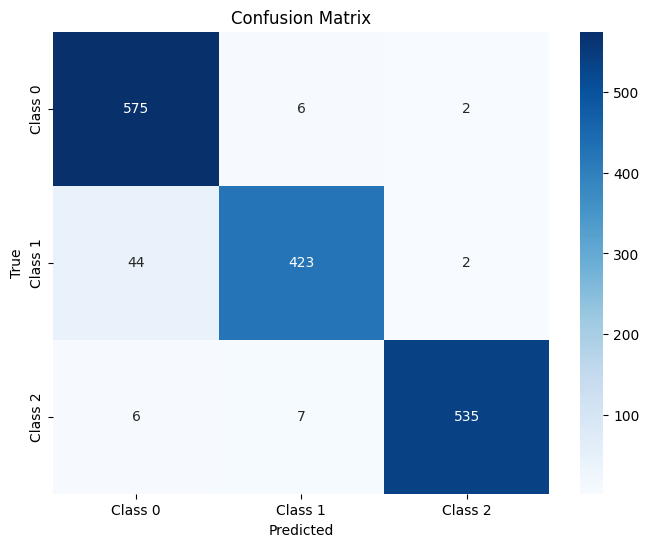

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'all_true_labels' and 'all_y_pred' are already defined

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()